In [1]:
%matplotlib nbagg
#import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools import *
from alvra_tools.channels import *

#from alvra_tools.channels_raw import *

In [9]:
#scan_name = "RuDimerACN_monoscan_0p6ps_020"
scan_name ="Na2S2O3-XAS"
#scan_range =".run002878-002922"
scan_range =".run000874-000894"



#DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
#DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

DIR = "/sf/alvra/data/p18387/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p18387/res/scan_info/"

#DIR = "/das/work/p17/p17983/Example_data/raw/scan_data/" + scan_name + "/"
#DIR_json = "/das/work/p17/p17983/Example_data/res/scan_info/"


!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)


total 38G
-rw-r--r--. 1 root p18387 531M Feb 20 01:19 run_000853.BSREAD.h5
-rw-r--r--. 1 root p18387 635M Feb 20 01:19 run_000853.BSREAD.IMAGES.h5
drwxrwsr-x. 9 root p18387 4.0K Feb 20 01:19 ..
-rw-r--r--. 1 root p18387 531M Feb 20 01:19 run_000854.BSREAD.h5
-rw-r--r--. 1 root p18387 636M Feb 20 01:19 run_000854.BSREAD.IMAGES.h5
-rw-r--r--. 1 root p18387 531M Feb 20 01:20 run_000855.BSREAD.h5
-rw-r--r--. 1 root p18387 636M Feb 20 01:20 run_000855.BSREAD.IMAGES.h5
-rw-r--r--. 1 root p18387 531M Feb 20 01:21 run_000856.BSREAD.h5
-rw-r--r--. 1 root p18387 636M Feb 20 01:21 run_000856.BSREAD.IMAGES.h5
-rw-r--r--. 1 root p18387 531M Feb 20 01:22 run_000857.BSREAD.h5
-rw-r--r--. 1 root p18387 635M Feb 20 01:22 run_000857.BSREAD.IMAGES.h5
-rw-r--r--. 1 root p18387 531M Feb 20 01:23 run_000858.BSREAD.h5
-rw-r--r--. 1 root p18387 634M Feb 20 01:23 run_000858.BSREAD.IMAGES.h5
-rw-r--r--. 1 root p18387 531M Feb 20 01:24 run_000859.BSREAD.h5
-rw-r--r--. 1 root p18387 634M Feb 20 01:24 run_000859.B

# Load one step and filter some data from I0

In [10]:
f ="run_000876.BSREAD.h5"
fn = DIR + f

DataFEL_t, DataFEL_f, IzeroFEL, Laser, Variable, PulseIDs = load_FEL_scans(fn, channel_energy)

IzeroFEL_original = IzeroFEL.copy()
print (np.median(IzeroFEL))# - 2*(np.std(IzeroFEL_pump_shot)))

conditionMax = IzeroFEL < np.median(IzeroFEL)+3*(np.std(IzeroFEL))
conditionMin = IzeroFEL > np.median(IzeroFEL)-3*(np.std(IzeroFEL))

conditionGeneral = IzeroFEL > 0

IzeroFEL = IzeroFEL[conditionMin & conditionMax & conditionGeneral]
#IzeroFEL = [x for x in IzeroFEL if (np.abs(x) > 1000)]

0.05009036744013429


<IPython.core.display.Javascript object>


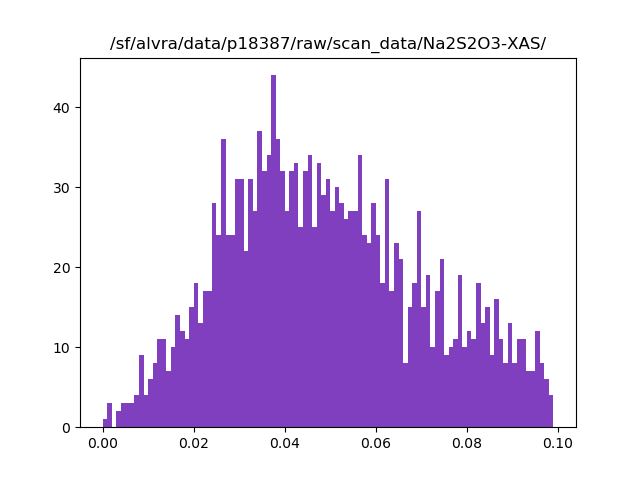

2000 1965


In [11]:
#num_bins = 100
plt.figure()
plt.hist(IzeroFEL_original, bins =np.arange(0,0.1,0.001), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL, bins =np.arange(0,0.1,0.001), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.title(DIR)
plt.show()
print (IzeroFEL_original.size, IzeroFEL.size)

# Load mono scan

In [12]:
scan_name ="Na2S2O3-XAS"         # you need to change only this name

######################################################################################

json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

DataFluo = []
DataTrans = []
err_DataFluo = []
err_DataTrans = []
Energy_eV = []

clock = Clock()
print("\nProcessing", numFiles, "files total")

for i in range(0,numFiles):             
    fn_BS = str(data['scan_files'][i][0])    
    exists = os.path.isfile(fn_BS)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        DataFEL_trans, DataFEL_fluo, IzeroFEL, Laser, energy_shot, PulseIDs = load_FEL_scans(fn_BS, channel_energy)
        
        threshold_Izero = IzeroFEL > 0.0001
        
        conditionMax = IzeroFEL < np.median(IzeroFEL)+3*(np.std(IzeroFEL))
        conditionMin = IzeroFEL > np.median(IzeroFEL)-3*(np.std(IzeroFEL))
              
        DataFEL_trans = DataFEL_trans[threshold_Izero & conditionMax & conditionMin]
        DataFEL_fluo = DataFEL_fluo[threshold_Izero & conditionMax & conditionMin]
        IzeroFEL = IzeroFEL[threshold_Izero & conditionMax & conditionMin]
        
        DataFEL_trans_norm = DataFEL_trans / IzeroFEL
        DataFEL_fluo_norm = DataFEL_fluo / IzeroFEL
        
        DataFluo.append(DataFEL_fluo_norm.mean())
        DataTrans.append(DataFEL_trans_norm.mean())
        
        err_DataFluo.append(DataFEL_fluo_norm.std()/np.sqrt(DataFEL_fluo_norm.size))
        err_DataTrans.append(DataFEL_trans_norm.std()/np.sqrt(DataFEL_trans_norm.size))
            
        energy_shot = [x for x in energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_shot))
    
DataFluo = np.asarray(DataFluo)
DataTrans = np.asarray(DataTrans)
err_DataFluo = np.asarray(err_DataFluo)
err_DataTrans = np.asarray(err_DataTrans)
            
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")


/sf/alvra/data/p18387/res/scan_info/Na2S2O3-XAS.run000874-000894.json

Processing 14 files total
step 1 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000874.BSREAD.h5
step 2 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000875.BSREAD.h5
step 3 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000876.BSREAD.h5
step 4 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000877.BSREAD.h5
step 5 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000878.BSREAD.h5
step 6 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000879.BSREAD.h5
step 7 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000880.BSREAD.h5
step 8 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000881.BSREAD.h5
step 9 of 14 : Processing /sf/alvra/data/p18387/raw/scan_data/Na2S2O3-XAS/run_000882.BSREAD.h5
step 10 of 14 : Processing /sf/alvra/data/p18387

# Plot energy scans

<IPython.core.display.Javascript object>


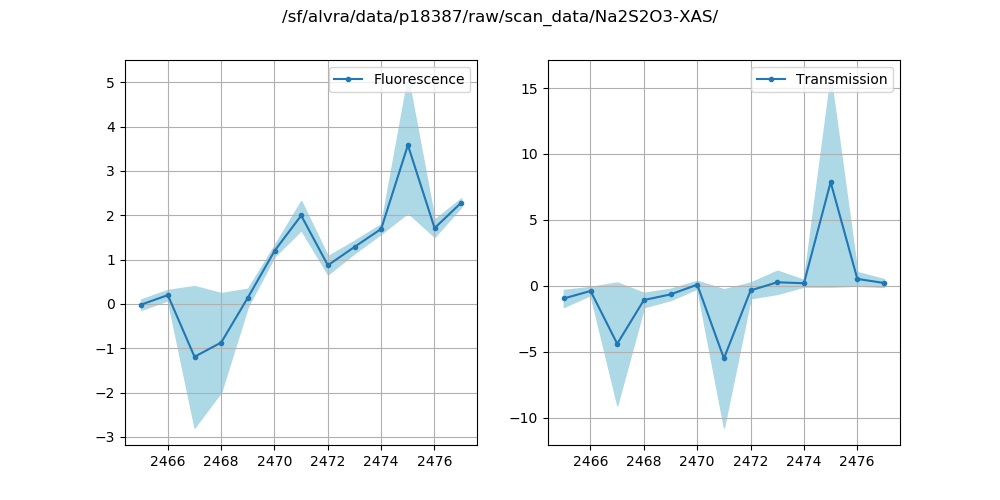

In [13]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
#plt.title(DIR,horizontalalignment='right')

low_err_Fluo = DataFluo - err_DataFluo
high_err_Fluo = DataFluo + err_DataFluo
low_err_Trans = DataTrans - err_DataTrans
high_err_Trans = DataTrans + err_DataTrans

plt.subplot(1,2,1)
plt.plot(Energy_eV, DataFluo, label="Fluorescence",marker='.')
plt.fill_between(Energy_eV, scale*low_err_Fluo, scale*high_err_Fluo, color='lightblue')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Energy_eV, DataTrans, label="Transmission",marker='.')
plt.fill_between(Energy_eV, scale*low_err_Trans, scale*high_err_Trans, color='lightblue')
plt.legend(loc="best")
plt.grid()

plt.show()

# Summing scans

## Plotting sumed scans